### PyTorch : Tensors
- n-dimensional array
- can utilise GPUs

### Two layer neural network in PyTorch

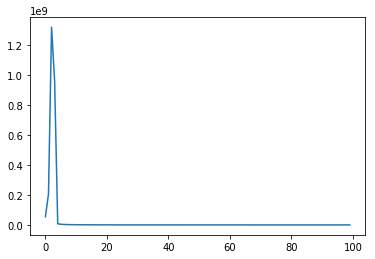

In [21]:
import torch
import matplotlib.pyplot as plt
import numpy as np

dtype = torch.float
device = torch.device("cuda:0")
# device = torch.device("cpu") #Uncomment this to run on GPU

num_examples = 128
Batch_size, D_in, H, D_out = 64, 1000, 100, 10

# create random input and output data
x = torch.randn(num_examples, D_in, device=device, dtype=dtype)
y = torch.randn(num_examples, D_out, device=device, dtype=dtype)

# Radomly initialize weights
w1 = torch.randn(D_in, H, device=device, dtype=dtype)
w2 = torch.randn(H, D_out, device=device, dtype=dtype)

lr = 1e-6
losses = [] # better to display instead of print many numbers

for i in range(100):
    # Forward pass
    h = x.mm(w1)   # mm --> matrix multiplication 
    h_relu = h.clamp(min=0)
    y_pred = h_relu.mm(w2)

    # Compute and print loss
    loss = (y_pred - y).pow(2).sum().item()
    losses.append(loss)  

    # Backprop to compute gradients of w1 and w2
    grad_y_pred = 2.0 * (y_pred - y)
    grad_w2 = h_relu.t().mm(grad_y_pred)
    grad_h_relu = grad_y_pred.mm(w2.t())
    grad_h = grad_h_relu.clone()
    grad_h[h<0] = 0
    grad_w1 = x.t().mm(grad_h)

    # update weights using gradients
    w1 -= lr*grad_w1 
    w2 -= lr*grad_w2

# Plot the loss
plt.plot(np.arange(len(losses)), losses)

### Autograd

As we proceed further it gets very difficult to write code for Backpropagation ourselves. So to help us out, we can use ***automatic differentiation*** using the ***autograd*** package in pytorch. Hence, we just have to define the ***computational graph*** for forward pass and autograd handles the backward pass.

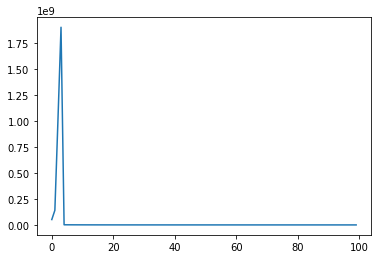

In [18]:
# We will use some of the variables defined above.

# Create random tensors for weights
# Setting autograd=True indicates that we want to compute gradients with 
# respect to these Tensors during the backward pass
w1 = torch.randn(H, D_in, device=device, dtype=dtype, requires_grad=True)
w2 = torch.randn(D_out, H, device=device, dtype=dtype, requires_grad=True)
losses = []

for t in range(100):
    # same operations as above
    y_pred = w2.mm(w1.mm(x).clamp(min=0))

    # compute loss
    loss = ((y_pred - y)**2).sum()
    losses.append(loss.item())

    # Use autograd to compute the backward pass. This call will compute the 
    # gradient of loss with respect to all tensors with require_grad = True
    loss.backward()

    # Manually update the weights using gradient descent
    # So we will set all require_grad = False 
    with torch.no_grad():
        w1 -= lr * w1.grad
        w2 -= lr * w2.grad

        # Manually zero the gradients after updating weights
        w1.grad.zero_()
        w2.grad.zero_()

# Plot the loss
plt.plot(np.arange(len(losses)), losses)

### Defining new autograd functions

In PyTorch we can easily define our own autograd operator by defining a subclass of <b><i>torch.autograd.Function</i></b> and implementing the <b>forward</b> and ***backward*** functions.

In [0]:
class MyReLU(torch.autograd.Function):
    """
    Custom autograd function
    """

    @staticmethod
    def forward(ctx, input):
        """
        ctx - cache to save stuff for backward pass
        input - to be processed and given output
        """
        ctx.save_for_backward(input)
        return input.clamp(min=0)

    @staticmethod
    def backward(ctx, grad_output):
        """
        ctx - cache saved during forward pass
        grad_output - gradient of the loss w.r.t outupt, and 
                we have to compute gradient of loss w.r.t input
        """
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad_input[input < 0] = 0
        return grad_input 

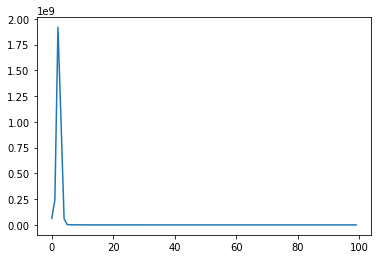

In [19]:
w1 = torch.randn(H, D_in, device=device, dtype=dtype, requires_grad=True)
w2 = torch.randn(D_out, H, device=device, dtype=dtype, requires_grad=True)
losses = []

for t in range(100):
    # to apply our Function we use Function.apply methd. We alias this as 'relu'
    relu = MyReLU.apply
    
    # Here we use our self defined relu function
    y_pred = w2.mm(relu(w1.mm(x)))

    loss = ((y_pred - y)**2).sum()
    losses.append(loss.item())

    # use autograd
    loss.backward()

    with torch.no_grad():
        w1 -= lr * w1.grad
        w2 -= lr * w2.grad

        w1.grad.zero_()
        w2.grad.zero_()

# Plot the loss
plt.plot(np.arange(len(losses)), losses)

## nn module

We generally think of neural networks in terms of layers, some of which have ***learnable parameters*** which are optimized during learning. In tensorflow, packages such as Keras provide this higher-level abstraction. In PyTorch, <i>**nn**<i> package serves the same purpose.

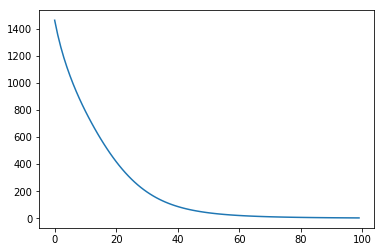

In [4]:
# Use nn package to implement a two layer neural network

x = torch.randn(num_examples, D_in)
y = torch.randn(num_examples, D_out)

# Define the model
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out)
    )

# Define the loss function
# reduction is set to sum
loss_fn = torch.nn.MSELoss(reduction='sum')
losses = []

lr = 1e-4
for t in range(100):
    # compute y by passing x to the model
    y_pred = model(x)

    # compute loss
    loss = loss_fn(y_pred, y)
    losses.append(loss.item())

    # Zero the gradients before running backward pass
    model.zero_grad()

    # Compute the gradients for all learnable params in model
    loss.backward()

    # Update the weights using gradient descent (manually)
    # Note that even this can be automated using built in optimizers 
    with torch.no_grad():
        for param in model.parameters():
            param -= lr*param.grad

# Plot the loss
plt.plot(np.arange(len(losses)), losses)

### PyTorch:optim

The optim package in PyTorch has implementations of commonly used optimization algorithms and thus we can avoid doing manual updates to the weights as done until now.

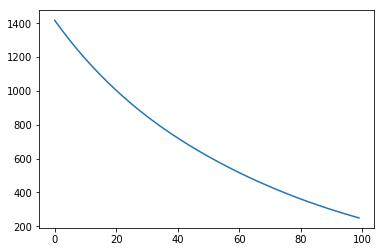

In [22]:
# Use nn package to implement a two layer neural network

x = torch.randn(num_examples, D_in)
y = torch.randn(num_examples, D_out)

# Define the model
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out)
    )

# Define the loss function
# reduction is set to sum
loss_fn = torch.nn.MSELoss(reduction='sum')
losses = []

lr = 1e-4
# Use the optim package to define an Optimizer that will update the model's parameters
# The first argument to the Adam Constructor tells the optimizer which Tensors it should update
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for t in range(100):
    # compute y by passing x to the model
    y_pred = model(x)

    # compute loss
    loss = loss_fn(y_pred, y)
    losses.append(loss.item())

    # Zero the gradients for the tensors which the optimizer will update
    # because the grads are stored in buffers(i.e, not overwritten) whenever
    # .backward() is called
    optimizer.zero_grad()

    loss.backward()

    #Calling the step function on an Optimizer makes an update to its parameters
    optimizer.step()

# Plot the loss
plt.plot(np.arange(len(losses)), losses)

### Custom nn Modules

For cases when we require models which are different than existing models, we can subclass ***nn.Module*** and define a ***forward*** which receives input Tensors and produces output Tensors.

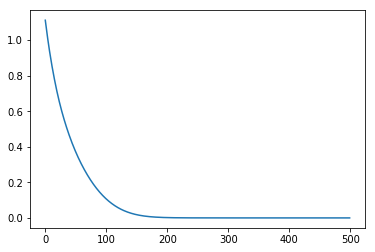

In [2]:
# Custom Network
class TwoLayerNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(TwoLayerNet, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out)

    def forward(self, x):
        """
        Use modules defined in __init__ to process the input
        """
        h_relu = self.linear1(x).clamp(min=0)
        y_pred = self.linear2(h_relu)
        return y_pred

N, D_in, H, D_out = 64, 1000, 100, 10

x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

# initialise custom model
model = TwoLayerNet(D_in, H, D_out)
loss_fn = torch.nn.MSELoss()
losses = []
optim = torch.optim.Adam(model.parameters(), lr=1e-4)

for t in range(500):
    y_pred = model(x)
    loss = loss_fn(y_pred, y)  # calculate loss
    losses.append(loss)
    optim.zero_grad() 
    loss.backward()   # backprop
    optim.step()      # grad descent

plt.plot(np.arange(len(losses)), losses)

That's it for now.